<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [36]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
import io
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tommykamaz/faces-dataset-small

100% 3.99G/3.99G [01:44<00:00, 40.6MB/s]
100% 3.99G/3.99G [01:44<00:00, 40.8MB/s]


In [4]:
!mkdir images
!unzip -q -o faces-dataset-small.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'
DATA_DIR = './images/'

In [5]:
image_size = 128
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
latent_size = 128


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [7]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [8]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [9]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [12]:
def get_dataloader(DATA_DIR, image_size, batch_size, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl

In [13]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
loader = get_dataloader(DATA_DIR, image_size, batch_size, stats)

In [15]:
loader = DeviceDataLoader(loader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [16]:
discriminator = nn.Sequential(
    #in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 64 x 64 x 64

    nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()).to(device)

In [17]:

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
).to(device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [18]:
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [19]:
def fit(model, criterion, epochs, lr):
  model["discriminator"].train()
  model["generator"].train()
  torch.cuda.empty_cache()
  
  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
  
  # Create optimizers
  optimizer = {
      "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                        lr=lr, betas=(0.5, 0.999)),
      "generator": torch.optim.Adam(model["generator"].parameters(),
                                    lr=lr, betas=(0.5, 0.999))
  }
  
  for epoch in range(epochs):
      loss_d_per_epoch = []
      loss_g_per_epoch = []
      real_score_per_epoch = []
      fake_score_per_epoch = []
      for real_images, _ in tqdm(loader):
          # Train discriminator
          # Clear discriminator gradients
          optimizer["discriminator"].zero_grad()

          # Pass real images through discriminator
          real_preds = model["discriminator"](real_images)
          real_targets = torch.ones(real_images.size(0), 1, device=device)
          real_loss = criterion["discriminator"](real_preds, real_targets)
          cur_real_score = torch.mean(real_preds).item()
          
          # Generate fake images
          latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          fake_images = model["generator"](latent)

          # Pass fake images through discriminator
          fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
          fake_preds = model["discriminator"](fake_images)
          fake_loss = criterion["discriminator"](fake_preds, fake_targets)
          cur_fake_score = torch.mean(fake_preds).item()

          real_score_per_epoch.append(cur_real_score)
          fake_score_per_epoch.append(cur_fake_score)

          # Update discriminator weights
          loss_d = real_loss + fake_loss
          loss_d.backward()
          optimizer["discriminator"].step()
          loss_d_per_epoch.append(loss_d.item())


          # Train generator
          # Clear generator gradients
          optimizer["generator"].zero_grad()
          
          # Generate fake images
          latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          fake_images = model["generator"](latent)
          
          # Try to fool the discriminator
          preds = model["discriminator"](fake_images)
          targets = torch.ones(batch_size, 1, device=device)
          loss_g = criterion["generator"](preds, targets)
          
          # Update generator weights
          loss_g.backward()
          optimizer["generator"].step()
          loss_g_per_epoch.append(loss_g.item())
          
      # Record losses & scores
      losses_g.append(np.mean(loss_g_per_epoch))
      losses_d.append(np.mean(loss_d_per_epoch))
      real_scores.append(np.mean(real_score_per_epoch))
      fake_scores.append(np.mean(fake_score_per_epoch))
      
      # Log losses & scores (last batch)
      print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, epochs, 
          losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
  
      # Save generated images
      if epoch == epochs - 1:
        save_samples(epoch + 1, fixed_latent, show=False)
  
  return losses_g, losses_d, real_scores, fake_scores

In [184]:
%%time
history = fit(model, criterion, 110, lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/110], loss_g: 10.9911, loss_d: 0.4223, real_score: 0.9156, fake_score: 0.1156


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/110], loss_g: 9.5806, loss_d: 0.2710, real_score: 0.9302, fake_score: 0.0851


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/110], loss_g: 8.1833, loss_d: 0.1905, real_score: 0.9411, fake_score: 0.0593


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/110], loss_g: 8.1248, loss_d: 0.1673, real_score: 0.9491, fake_score: 0.0332


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/110], loss_g: 7.4664, loss_d: 0.1942, real_score: 0.9427, fake_score: 0.0564


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/110], loss_g: 7.8845, loss_d: 0.1008, real_score: 0.9661, fake_score: 0.0253


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/110], loss_g: 7.0178, loss_d: 0.2100, real_score: 0.9367, fake_score: 0.0541


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/110], loss_g: 5.2162, loss_d: 0.5789, real_score: 0.8196, fake_score: 0.1642


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/110], loss_g: 4.0839, loss_d: 0.6889, real_score: 0.8053, fake_score: 0.1869


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/110], loss_g: 3.8211, loss_d: 0.6404, real_score: 0.8007, fake_score: 0.2004


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/110], loss_g: 4.0952, loss_d: 0.7249, real_score: 0.7728, fake_score: 0.2281


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/110], loss_g: 3.9731, loss_d: 0.7534, real_score: 0.7643, fake_score: 0.2358


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/110], loss_g: 3.9295, loss_d: 0.7934, real_score: 0.7515, fake_score: 0.2481


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/110], loss_g: 3.8825, loss_d: 0.7472, real_score: 0.7599, fake_score: 0.2406


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/110], loss_g: 4.1345, loss_d: 0.7301, real_score: 0.7606, fake_score: 0.2353


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/110], loss_g: 3.8321, loss_d: 0.8039, real_score: 0.7426, fake_score: 0.2541


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/110], loss_g: 3.7174, loss_d: 0.7227, real_score: 0.7607, fake_score: 0.2425


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/110], loss_g: 4.0639, loss_d: 0.7311, real_score: 0.7542, fake_score: 0.2367


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/110], loss_g: 3.8907, loss_d: 0.6591, real_score: 0.7763, fake_score: 0.2208


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/110], loss_g: 4.2546, loss_d: 0.7034, real_score: 0.7779, fake_score: 0.2208


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/110], loss_g: 3.8498, loss_d: 0.6195, real_score: 0.7811, fake_score: 0.2112


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/110], loss_g: 4.1278, loss_d: 0.5498, real_score: 0.8076, fake_score: 0.1910


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/110], loss_g: 4.4174, loss_d: 0.5962, real_score: 0.8005, fake_score: 0.1998


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/110], loss_g: 4.4654, loss_d: 0.5403, real_score: 0.8179, fake_score: 0.1838


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/110], loss_g: 4.2893, loss_d: 0.5922, real_score: 0.8049, fake_score: 0.1859


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/110], loss_g: 4.5881, loss_d: 0.4695, real_score: 0.8372, fake_score: 0.1664


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/110], loss_g: 4.6033, loss_d: 0.5153, real_score: 0.8312, fake_score: 0.1645


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/110], loss_g: 4.3947, loss_d: 0.4574, real_score: 0.8460, fake_score: 0.1546


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/110], loss_g: 4.3876, loss_d: 0.5921, real_score: 0.8037, fake_score: 0.1882


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/110], loss_g: 4.5845, loss_d: 0.5099, real_score: 0.8379, fake_score: 0.1640


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/110], loss_g: 4.8132, loss_d: 0.5141, real_score: 0.8283, fake_score: 0.1691


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/110], loss_g: 4.6134, loss_d: 0.5185, real_score: 0.8280, fake_score: 0.1707


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/110], loss_g: 4.5210, loss_d: 0.5456, real_score: 0.8230, fake_score: 0.1725


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/110], loss_g: 4.3322, loss_d: 0.3668, real_score: 0.8648, fake_score: 0.1378


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/110], loss_g: 4.6667, loss_d: 0.4198, real_score: 0.8506, fake_score: 0.1416


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/110], loss_g: 4.6484, loss_d: 0.4890, real_score: 0.8434, fake_score: 0.1601


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/110], loss_g: 4.6770, loss_d: 0.4526, real_score: 0.8507, fake_score: 0.1481


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/110], loss_g: 4.7515, loss_d: 0.4296, real_score: 0.8515, fake_score: 0.1441


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/110], loss_g: 4.6892, loss_d: 0.3438, real_score: 0.8749, fake_score: 0.1265


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/110], loss_g: 4.9847, loss_d: 0.5680, real_score: 0.8324, fake_score: 0.1701


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [41/110], loss_g: 4.4046, loss_d: 0.4216, real_score: 0.8534, fake_score: 0.1388


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [42/110], loss_g: 4.6361, loss_d: 0.4328, real_score: 0.8584, fake_score: 0.1405


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [43/110], loss_g: 4.9283, loss_d: 0.4728, real_score: 0.8521, fake_score: 0.1488


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [44/110], loss_g: 4.3607, loss_d: 0.4524, real_score: 0.8541, fake_score: 0.1428


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [45/110], loss_g: 4.5492, loss_d: 0.3239, real_score: 0.8831, fake_score: 0.1191


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [46/110], loss_g: 4.7757, loss_d: 0.3426, real_score: 0.8793, fake_score: 0.1199


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [47/110], loss_g: 5.3348, loss_d: 0.4173, real_score: 0.8628, fake_score: 0.1266


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [48/110], loss_g: 4.8932, loss_d: 0.4229, real_score: 0.8654, fake_score: 0.1411


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [49/110], loss_g: 5.0442, loss_d: 0.4221, real_score: 0.8787, fake_score: 0.1189


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [50/110], loss_g: 4.7396, loss_d: 0.3804, real_score: 0.8681, fake_score: 0.1303


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [51/110], loss_g: 4.8165, loss_d: 0.3511, real_score: 0.8775, fake_score: 0.1223


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [52/110], loss_g: 4.9973, loss_d: 0.3067, real_score: 0.8881, fake_score: 0.1066


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [53/110], loss_g: 4.8985, loss_d: 0.3530, real_score: 0.8800, fake_score: 0.1231


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [54/110], loss_g: 4.9654, loss_d: 0.3556, real_score: 0.8841, fake_score: 0.1131


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [55/110], loss_g: 4.9242, loss_d: 0.3365, real_score: 0.8865, fake_score: 0.1140


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [56/110], loss_g: 5.2998, loss_d: 0.3393, real_score: 0.8879, fake_score: 0.1051


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [57/110], loss_g: 5.0363, loss_d: 0.4178, real_score: 0.8682, fake_score: 0.1348


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [58/110], loss_g: 4.9041, loss_d: 0.2512, real_score: 0.9098, fake_score: 0.0917


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [59/110], loss_g: 4.8935, loss_d: 0.4406, real_score: 0.8685, fake_score: 0.1263


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [60/110], loss_g: 4.8415, loss_d: 0.3437, real_score: 0.8882, fake_score: 0.1143


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [61/110], loss_g: 4.7123, loss_d: 0.1650, real_score: 0.9315, fake_score: 0.0683


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [62/110], loss_g: 8.0438, loss_d: 0.3753, real_score: 0.9104, fake_score: 0.0881


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [63/110], loss_g: 5.1408, loss_d: 0.3771, real_score: 0.8801, fake_score: 0.1216


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [64/110], loss_g: 4.9611, loss_d: 0.3398, real_score: 0.8891, fake_score: 0.1111


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [65/110], loss_g: 4.6956, loss_d: 0.1933, real_score: 0.9234, fake_score: 0.0736


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [66/110], loss_g: 6.2366, loss_d: 0.4360, real_score: 0.8860, fake_score: 0.1152


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [67/110], loss_g: 4.6659, loss_d: 0.2997, real_score: 0.8949, fake_score: 0.1011


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [68/110], loss_g: 4.6631, loss_d: 0.3292, real_score: 0.8945, fake_score: 0.1030


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [69/110], loss_g: 4.9440, loss_d: 0.2522, real_score: 0.9109, fake_score: 0.0919


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [70/110], loss_g: 5.0447, loss_d: 0.2196, real_score: 0.9189, fake_score: 0.0811


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [71/110], loss_g: 5.7331, loss_d: 0.3839, real_score: 0.8872, fake_score: 0.1111


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [72/110], loss_g: 4.8683, loss_d: 0.2728, real_score: 0.9043, fake_score: 0.0939


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [73/110], loss_g: 4.9733, loss_d: 0.3897, real_score: 0.8860, fake_score: 0.1138


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [74/110], loss_g: 4.7996, loss_d: 0.1926, real_score: 0.9250, fake_score: 0.0711


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [75/110], loss_g: 5.2992, loss_d: 0.3774, real_score: 0.8905, fake_score: 0.1134


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [76/110], loss_g: 4.9384, loss_d: 0.1780, real_score: 0.9279, fake_score: 0.0692


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [77/110], loss_g: 5.2488, loss_d: 0.1552, real_score: 0.9397, fake_score: 0.0611


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [78/110], loss_g: 5.3684, loss_d: 0.4649, real_score: 0.8764, fake_score: 0.1219


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [79/110], loss_g: 4.9145, loss_d: 0.1877, real_score: 0.9307, fake_score: 0.0702


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [80/110], loss_g: 5.1736, loss_d: 0.1459, real_score: 0.9435, fake_score: 0.0560


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [81/110], loss_g: 5.5055, loss_d: 0.1211, real_score: 0.9489, fake_score: 0.0498


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [82/110], loss_g: 5.6940, loss_d: 0.5024, real_score: 0.8775, fake_score: 0.1228


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [83/110], loss_g: 5.1489, loss_d: 0.2193, real_score: 0.9193, fake_score: 0.0798


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [84/110], loss_g: 5.1839, loss_d: 0.4552, real_score: 0.8764, fake_score: 0.1221


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [85/110], loss_g: 5.0464, loss_d: 0.2362, real_score: 0.9185, fake_score: 0.0812


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [86/110], loss_g: 5.2262, loss_d: 0.1922, real_score: 0.9304, fake_score: 0.0725


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [87/110], loss_g: 5.5470, loss_d: 0.3603, real_score: 0.8961, fake_score: 0.1022


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [88/110], loss_g: 4.8454, loss_d: 0.1655, real_score: 0.9343, fake_score: 0.0627


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [89/110], loss_g: 5.2595, loss_d: 0.1868, real_score: 0.9323, fake_score: 0.0702


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [90/110], loss_g: 5.5955, loss_d: 0.1773, real_score: 0.9341, fake_score: 0.0653


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [91/110], loss_g: 5.4664, loss_d: 0.4034, real_score: 0.8942, fake_score: 0.1057


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [92/110], loss_g: 4.9611, loss_d: 0.1203, real_score: 0.9476, fake_score: 0.0502


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [93/110], loss_g: 5.3782, loss_d: 0.2379, real_score: 0.9218, fake_score: 0.0802


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [94/110], loss_g: 5.6289, loss_d: 0.3195, real_score: 0.9037, fake_score: 0.0965


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [95/110], loss_g: 5.1249, loss_d: 0.1857, real_score: 0.9332, fake_score: 0.0648


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [96/110], loss_g: 5.8689, loss_d: 0.1574, real_score: 0.9419, fake_score: 0.0590


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [97/110], loss_g: 5.8787, loss_d: 0.2718, real_score: 0.9201, fake_score: 0.0749


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [98/110], loss_g: 5.6047, loss_d: 0.3353, real_score: 0.8997, fake_score: 0.1004


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [99/110], loss_g: 5.3029, loss_d: 0.2449, real_score: 0.9219, fake_score: 0.0825


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [100/110], loss_g: 5.1852, loss_d: 0.1280, real_score: 0.9462, fake_score: 0.0492


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [101/110], loss_g: 5.4482, loss_d: 0.2417, real_score: 0.9245, fake_score: 0.0785


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [102/110], loss_g: 5.3510, loss_d: 0.3497, real_score: 0.8998, fake_score: 0.0979


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [103/110], loss_g: 5.1162, loss_d: 0.1619, real_score: 0.9387, fake_score: 0.0596


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [104/110], loss_g: 5.1681, loss_d: 0.2484, real_score: 0.9177, fake_score: 0.0801


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [105/110], loss_g: 5.1210, loss_d: 0.2638, real_score: 0.9275, fake_score: 0.0782


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [106/110], loss_g: 5.2233, loss_d: 0.2025, real_score: 0.9375, fake_score: 0.0599


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [107/110], loss_g: 5.4484, loss_d: 0.1215, real_score: 0.9533, fake_score: 0.0493


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [108/110], loss_g: 5.3989, loss_d: 0.0956, real_score: 0.9591, fake_score: 0.0388


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [109/110], loss_g: 5.6389, loss_d: 0.0787, real_score: 0.9672, fake_score: 0.0340


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [110/110], loss_g: 6.0188, loss_d: 0.2337, real_score: 0.9252, fake_score: 0.0667
Saving generated-images-0110.png
CPU times: user 19min 38s, sys: 44.4 s, total: 20min 22s
Wall time: 3h 33min


In [23]:
#unpickle cuda model to cpu-only machine

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
with open('gan.pickle', 'rb') as f:
    model = CPU_Unpickler(f).load()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [213]:
losses_g, losses_d, real_scores, fake_scores = history

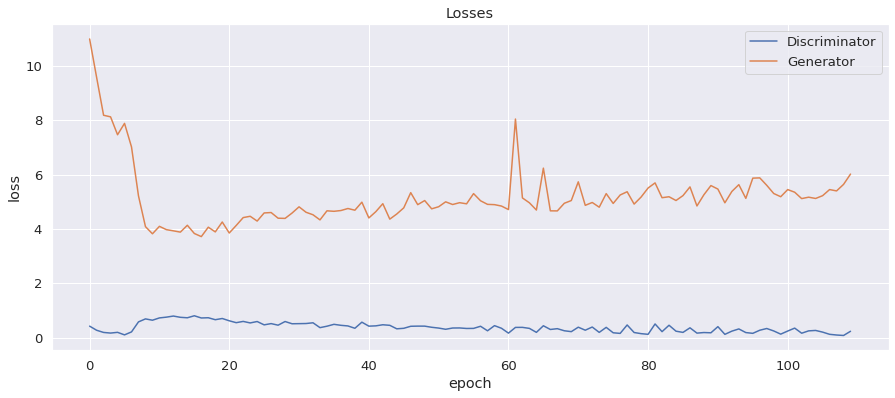

In [214]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Как и должно быть, лосс генератора сначала высокий, резко падает, а затем медленно растет. Лосс дискриминатора изначально маленький, затем слегка возрастает и плавно уменьшается.

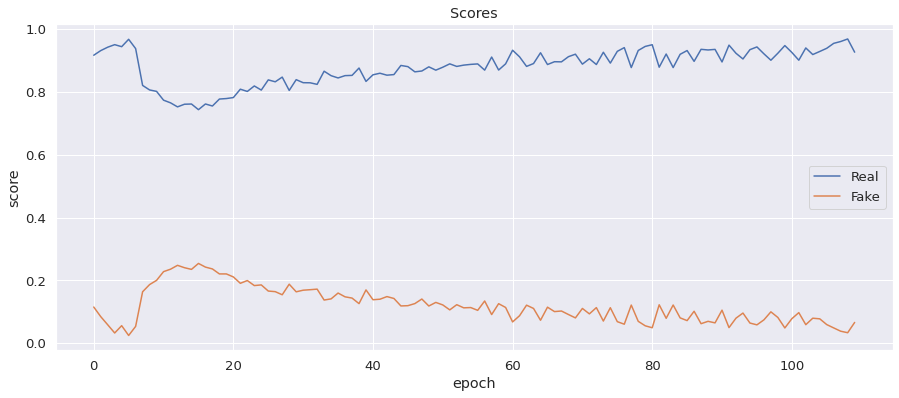

In [215]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Благодаря соревнованию моделей, мы можем увидеть лосс, который изображен на графике. 

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-0110.png')
generated_img = generated_img[:, :, [2, 1, 0]]

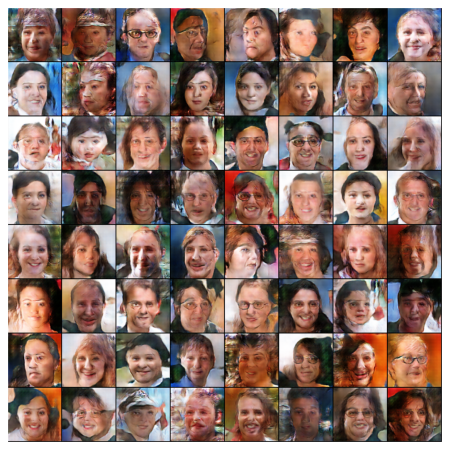

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

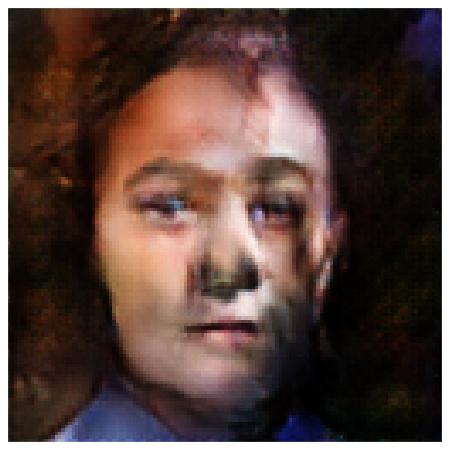

In [62]:
latent = torch.randn(1, latent_size, 1, 1, device=device)
fake_images = model["generator"](latent)
show_images(fake_images.cpu())

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [26]:
def get_dataset(DATA_DIR, image_siz, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  return train_ds

In [27]:
def generate_real_imgs():
    imgs = get_dataset(DATA_DIR, image_size, stats)
    targets = np.ones((len(imgs), 1))
    imgs = np.array([im.numpy() for im, _ in tqdm(imgs)])
    return imgs, targets


In [28]:
def generate_generated_imgs():
    latent = torch.randn(3143, latent_size, 1, 1, device=device)
    model["generator"].eval()
    with torch.no_grad():
        imgs = model["generator"](latent).cpu().numpy()
    targets = np.zeros((3143, 1))
    return imgs, targets


In [38]:
%%time
imgs_real, targets_real = generate_real_imgs()

  0%|          | 0/3143 [00:00<?, ?it/s]

CPU times: user 2min 31s, sys: 3.32 s, total: 2min 34s
Wall time: 2min 39s


In [39]:
imgs_generated, targets_generated = generate_generated_imgs()

In [29]:
X = np.concatenate((imgs_generated, imgs_real), axis=0)

In [30]:
y = np.concatenate((targets_generated, targets_real), axis=0)

In [31]:
loo = LeaveOneOut()
loo.get_n_splits(X)

6286

In [35]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [43]:
preds = np.array([])
for i, (train_index, test_index) in tqdm(enumerate(loo.split(X))):
    train = X[train_index].reshape(X[train_index].shape[0], -1)
    target = y[train_index]
    knn_model.fit(train, target. ravel())
    preds = np.append(preds, knn_model.predict(X[test_index].reshape(X[test_index].shape[0], -1)))
    if i % 1000 == 0:
        with open(f'/content/drive/MyDrive/preds_{i}.npy', 'wb') as f:
          np.save(f, preds)
          print(f"Save array with {i} predictions")

0it [00:00, ?it/s]

Save array with 0 predictions
Save array with 1000 predictions
Save array with 2000 predictions
Save array with 3000 predictions
Save array with 4000 predictions
Save array with 5000 predictions
Save array with 6000 predictions


In [44]:
accuracy_component = {'real': y, 'pred': preds}

In [45]:
with open('accuracy_component.pickle', 'wb') as f:
    pickle.dump(accuracy_component, f)

In [29]:
with open('accuracy_component.pickle', 'rb') as f:
    accuracy_component = pickle.load(f)

In [35]:
accuracy_score(accuracy_component['real'], accuracy_component['pred'])

0.8022589882278078

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

На самом деле, результат оставляет желать лучшего, потому что мы хотим получить accuracy 50%, потому что это скор "случайной модели"

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [43]:
vectrors_real = imgs_real.reshape(imgs_real.shape[0], -1)
vectrors_pred = imgs_generated.reshape(imgs_generated.shape[0], -1)

In [45]:
vectrors_real.shape

(3143, 49152)

In [46]:
%%time
real_emb = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(vectrors_real)
pred_emb = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(vectrors_pred)

CPU times: user 1min 43s, sys: 9.5 s, total: 1min 52s
Wall time: 1min 20s


Прокомментируйте получившийся результат:

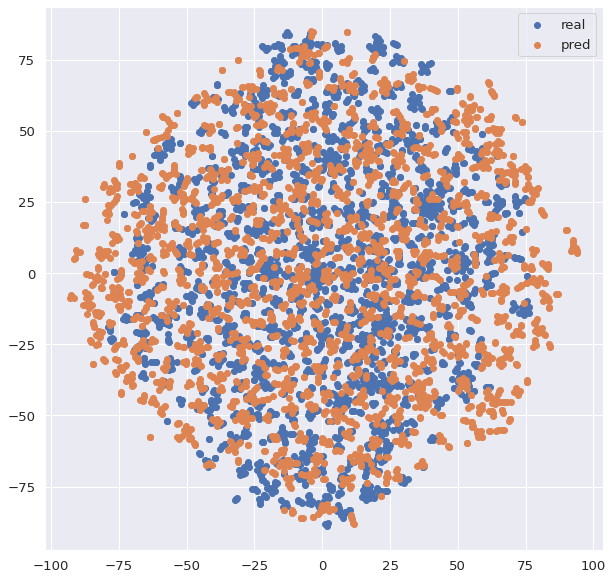

In [52]:
plt.figure(figsize=(10, 10))
plt.scatter(real_emb[:, 0], real_emb[:, 1], cmap='gist_rainbow', label = 'real')
plt.scatter(pred_emb[:, 0], pred_emb[:, 1], cmap='gist_rainbow', label = 'pred')
plt.legend()
plt.show()

Мы можем увидеть, что распределения сгенерированных картинок и картинок из датасета достаточно похожи, однако 'покрытие' сгенерированных картинок немного выходит за пределы покрытия настоящих картинок, что делает их точно классифицируемыми для 1-NN classifier, также мы видим большую дисперсию у сгенерированных картинок